In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import sys
import pandas as pd

import pickle
import glob
import re
import yaml
import torch

In [210]:
# folder = "/private/home/yuandong/dl_theory2/outputs/2019-07-31_16-56-31"
# folder = "/private/home/yuandong/dl_theory2/outputs/2019-07-31_17-13-50"
# folder = "/private/home/yuandong/dl_theory2/outputs/2019-07-31_17-33-24"
# folder = "/private/home/yuandong/dl_theory2/outputs/2019-07-31_17-48-46"
# folder = "/private/home/yuandong/dl_theory2/outputs/2019-07-31_17-54-12"
# folder = "/private/home/yuandong/dl_theory2/outputs/2019-07-31_19-31-35"
# folder = "/private/home/yuandong/dl_theory2/outputs/2019-07-31_19-51-27"
# folder = "/private/home/yuandong/dl_theory2/outputs/2019-07-31_21-07-40"
# m=50
# folder = "/private/home/yuandong/dl_theory2/outputs/2019-07-31_22-26-44"
# m = 5
folder = "/private/home/yuandong/dl_theory2/outputs/2019-07-31_22-47-05"
# m = 1, n = 2
# folder = "/private/home/yuandong/dl_theory2/outputs/2019-08-02_08-28-36"
# folder = "/private/home/yuandong/dl_theory2/outputs/2019-08-02_08-34-35"
# m = 1, n = 5
# folder = "/private/home/yuandong/dl_theory2/outputs/2019-08-02_08-35-26"
# m = 1, n = 10
# folder = "/private/home/yuandong/dl_theory2/outputs/2019-08-02_08-38-29"
# m = 1, n = 20
# folder = "/private/home/yuandong/dl_theory2/outputs/2019-08-02_08-48-36"
# folder = "/private/home/yuandong/dl_theory2/outputs/2019-08-02_11-22-18"
# m = 1, n = 3
# folder = "/private/home/yuandong/dl_theory2/outputs/2019-08-02_11-24-17"
args = yaml.load(open(os.path.join(folder, "config.yaml"), "r"))
stats = torch.load(os.path.join(folder, "stats.pickle"))
args

{'N': 10000,
 'bias': 0.0,
 'data_std': 1.5,
 'lr': 0.001,
 'm': 5,
 'multi': 10,
 'no_bias': False,
 'no_normalize': False,
 'num_iter': 100000,
 'print_iter': 1000,
 'seed': 2134,
 'use_sgd': False}

In [199]:
# Find correspondence between weights. 
def find_corr(w1, w2):
    inner_prod = w1.t() @ w2
    norm1 = w1.norm(dim=0)
    norm2 = w2.norm(dim=0)
    return inner_prod / norm1[:,None] / norm2[None,:]



In [60]:
max_corrs, max_indices = corrs.max(dim=1)

In [30]:
max_indices

tensor([ 1, 19])

In [31]:
max_corrs

tensor([0.9998, 0.9999], dtype=torch.float64)

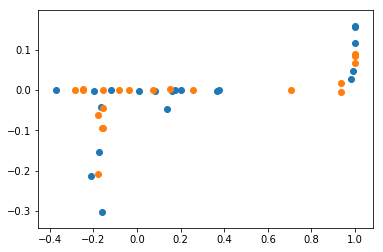

In [61]:
for teacher_idx in (0, 1):
    plt.scatter(corrs[teacher_idx], stats[-1]["W2_s"][:-1, teacher_idx])

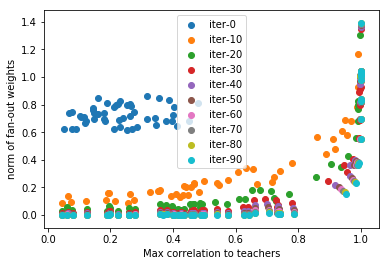

In [225]:
# s = stats[-1]

for it in range(0, 100, 10):
    s = stats[it]

    corrs = find_corr(stats[0]["W1_t"], s["W1_s"])

    norms = s["W2_s"].norm(dim=1)
    norms = norms[:-1]

    plt.scatter(corrs.max(dim=0)[0], norms, label=f"iter-{it}")
    plt.xlabel('Max correlation to teachers')
    plt.ylabel('norm of fan-out weights')
    
plt.legend()


# plt.savefig("corr-weight-norm.pdf")

In [219]:
(corrs > 0.9).sum(dim=1)

tensor([7, 2, 2, 2, 1])

In [67]:
stats[-1]["W2_s"][:-1, 0]

tensor([ 1.5604e-01, -2.0407e-03,  4.6116e-04, -2.1292e-01, -3.0339e-01,
         1.1618e-01, -4.1202e-02, -2.1286e-03,  4.5965e-02,  2.6340e-02,
        -1.4939e-03, -1.6684e-04,  4.2199e-04, -4.6747e-02,  1.5905e-01,
        -3.7401e-03, -1.4358e-03, -1.5480e-01, -1.0266e-04,  3.2229e-04],
       dtype=torch.float64)

teacher norm: tensor([4.3373, 2.1902, 1.3693, 1.1908, 1.0223, 0.0000], dtype=torch.float64)


/private/home/yuandong/miniconda3/envs/go10/lib/python3.6/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.


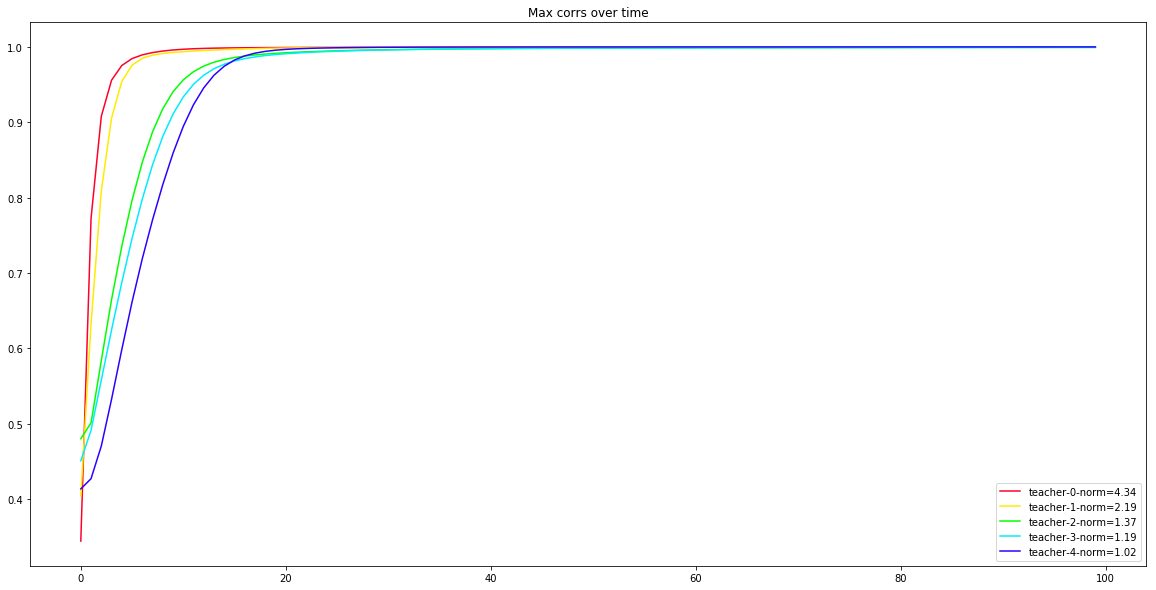

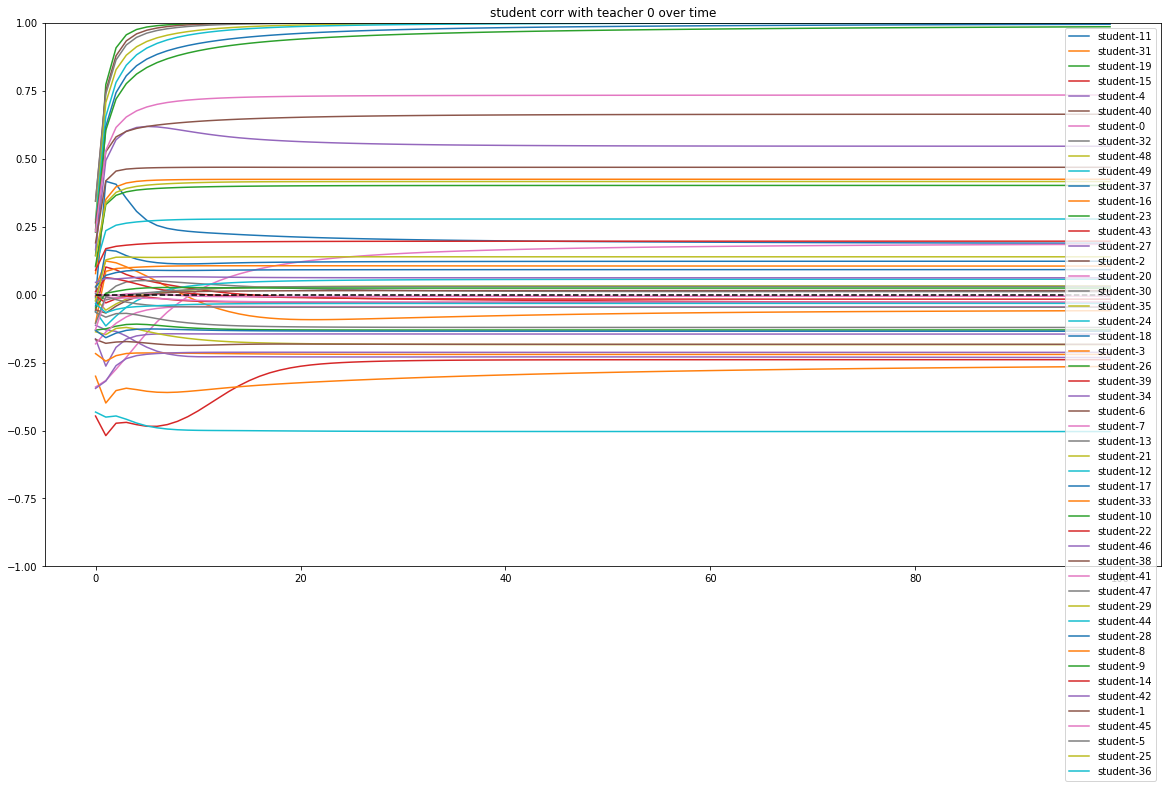

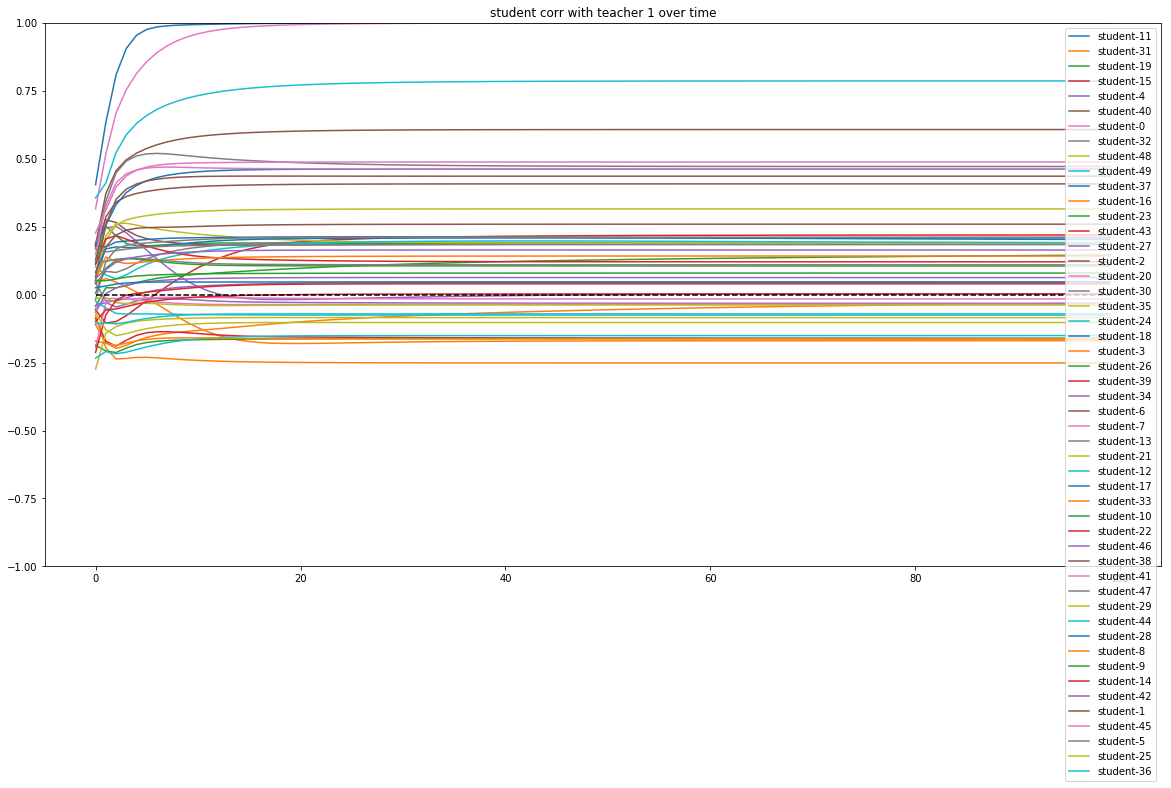

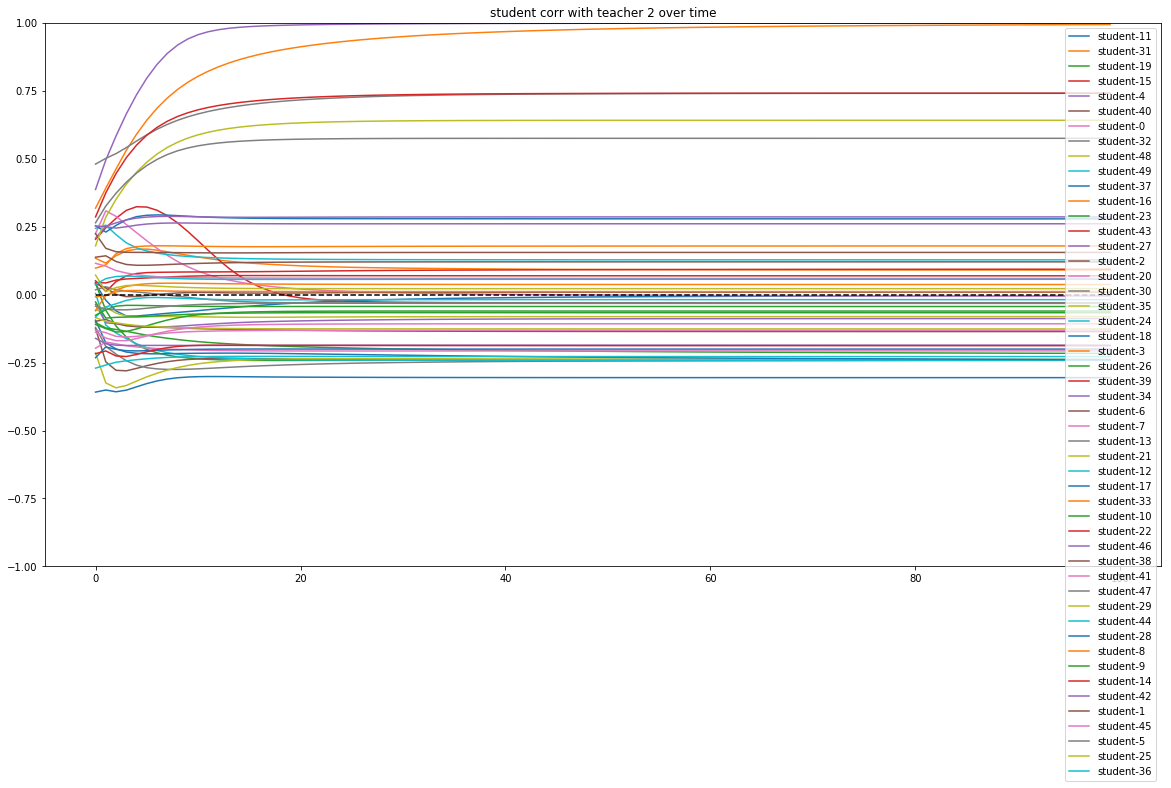

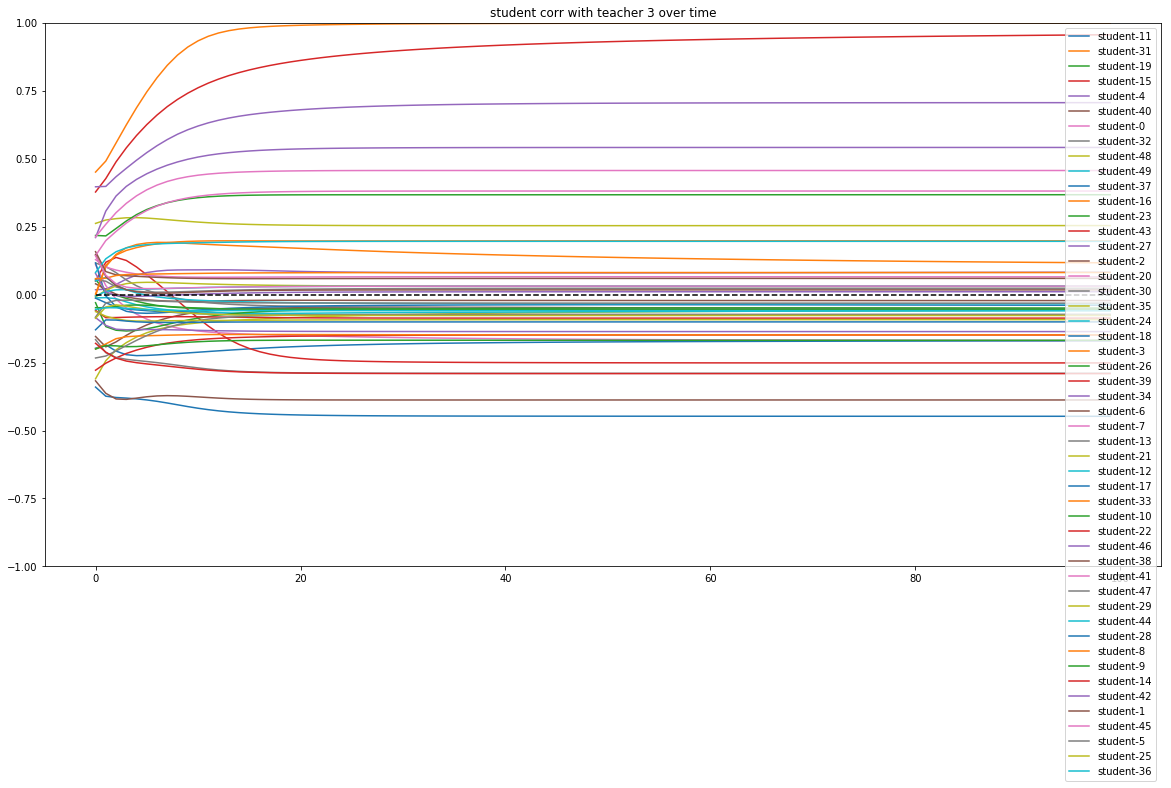

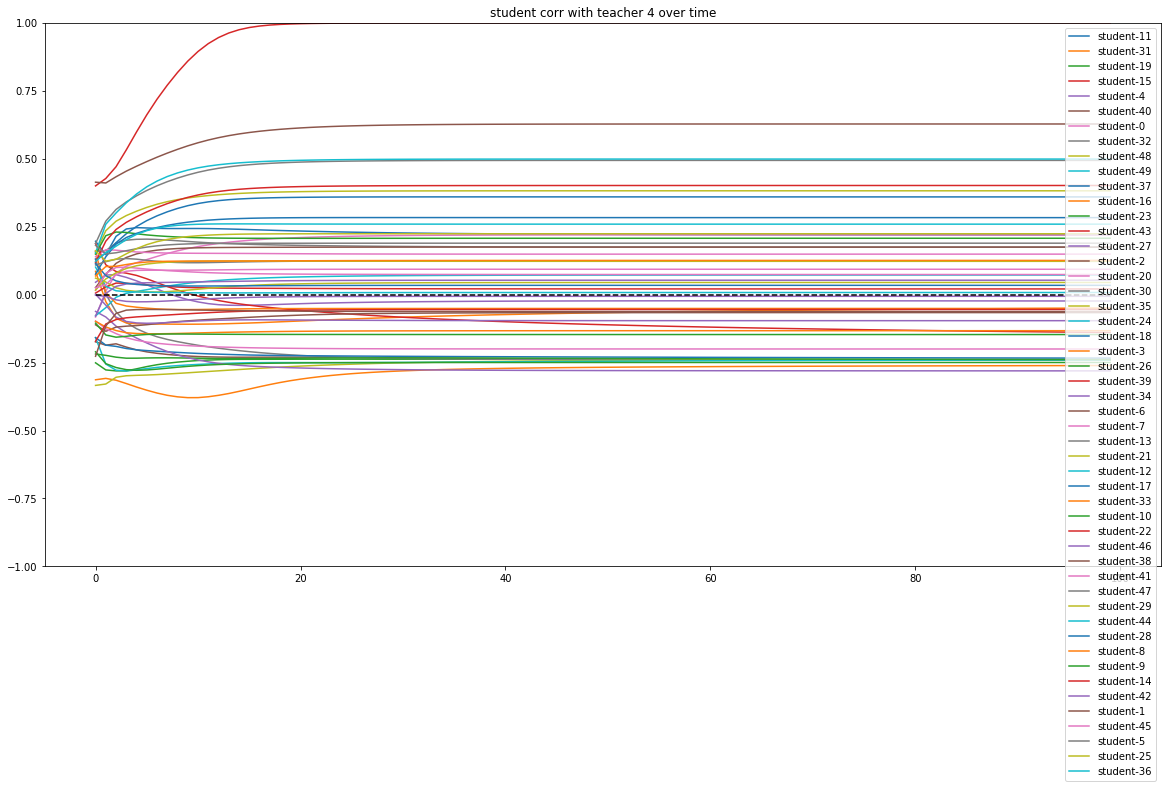

In [221]:
W2_t = stats[0]["W2_t"]
m = W2_t.size(0) - 1
t_norms = W2_t.norm(dim=1)
print(f"teacher norm: {t_norms}")

W1_t = stats[0]["W1_t"]

n = stats[-1]["W2_s"].size(0) - 1

num_iter = len(stats[1:])
traj_max = torch.FloatTensor(m, num_iter)
traj_max_student = torch.FloatTensor(m, n, num_iter)

norms = stats[-1]["W2_s"].norm(dim=1)
norms = norms[:-1]
sel_student_indices = norms.sort(descending=True)[1][:50]

for t, s in enumerate(stats[1:]):
    corrs = find_corr(W1_t, s["W1_s"])
    traj_max[:, t] = corrs.max(dim=1)[0]
    traj_max_student[:, :, t] = corrs #corrs.max(dim=0)[0]
    
cm = plt.get_cmap('gist_rainbow')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.set_color_cycle([cm(1.*i/m) for i in range(m)])
for i in range(m):
    plt.plot(traj_max[i, :].numpy(), label=f"teacher-{i}-norm={t_norms[i]:.2f}")
plt.legend()
plt.title('Max corrs over time')
plt.savefig("max-corr-over-time.pdf")

for j in range(m):
    plt.figure(figsize=(20, 10))
    for i in sel_student_indices: # range(n):
        plt.plot(traj_max_student[j, i, :].numpy(), label=f"student-{i}")
    plt.plot([0] * num_iter, linestyle='--', color='k')
    plt.legend()
    plt.axis([None, None, -1.0, 1.0])
    plt.title(f'student corr with teacher {j} over time')
    plt.savefig(f"student-corr-with-teacher-{j}.pdf")

In [ ]:
beta_start = (stats[0]["W2_s"] @ stats[0]["W2_t"].t())[:, 0]
beta_end = stats[-1]["W2_s"] @ stats[0]["W2_t"].t()[:, 0]
n = beta_start.size(0)

plt.plot(beta_start.numpy(), label="beta_start")
plt.plot(beta_end.numpy(), label="beta_end")
plt.plot([0] * n, color='k', linestyle='--')
plt.xticks(list(range(n)))
plt.legend()
plt.show()

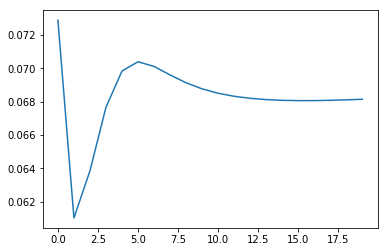

In [194]:
plt.plot(traj_max_student[0, 6, :].numpy(), label=f"student-2")